In [1]:
from tslearn.utils import to_time_series_dataset
import json
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

label_df = pd.read_csv('/home/woody/iwso/iwso092h/empkins/notebooks/labels.csv')
parent_dir = '/home/vault/empkins/tpD/D02/Students/Aditya/facau_data'
ids = os.listdir(parent_dir)
ids = os.listdir(parent_dir)

numeric_ids = [id for id in ids if id.isdigit()]

/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
valid_ids = []

coping_list = []

ids = os.listdir(parent_dir)
for id in ids:
    tagret_path = os.path.join(parent_dir, str(id), 'coping.json')
    if os.path.isfile(tagret_path):  # Check if the file exists
        try:
            with open(tagret_path, 'r') as f:
                coping_data = json.load(f)
            df = pd.DataFrame.from_dict(coping_data)
            if not df.empty:
                coping_list.append(df)
                valid_ids.append(int(id))  # Add valid ID to the list
        except (FileNotFoundError, ValueError, json.JSONDecodeError):
            pass

id_df = pd.DataFrame({'Participant ID': valid_ids})

label_df['Participant ID'] = label_df['Participant ID'].astype(int)

# Merge combined_df with id_df to rearrange according to the directory IDs
reordered_df = id_df.merge(label_df, on='Participant ID', how='left')
reordered_df.shape
len(coping_list)
coping_list = [df for df in coping_list if len(df) > 0]

columns_to_include = [
    'fac_AU01int',  # Inner Brow Raiser
    'fac_AU04int',  # Brow Lowerer
    # 'fac_AU06int',  # Cheek Raiser
    # 'fac_AU12int',  # Lip Corner Puller
    'fac_AU15int',  # Lip Corner Depressor
    # 'fac_AU17int'   # Chin Raiser
]

filtered_dataframes = [df[columns_to_include] for df in coping_list]

# for i, df in enumerate(filtered_dataframes):
#     print(f"DataFrame {i} shape: {df.shape}")
#     print(f"DataFrame {i} columns: {df.columns.tolist()}")

coping_list = filtered_dataframes

y = reordered_df['Label']
y = pd.Series(y)
if y.isna().sum() > 0:
    print(f"Found {y.isna().sum()} NaN values in the labels. Handling them...")
    y.fillna(y.mode()[0], inplace=True)
y = y.apply(lambda x: 0 if x == 0.5 else x).astype(int)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
dataframes = coping_list

max_length_limit = 10000  

max_length = min(max(df.shape[0] for df in dataframes), max_length_limit)

def pad_or_trim_dataframe(df, max_length):
    if df.shape[0] > max_length:
        return df.iloc[:max_length].to_numpy()
    else:
        padding_length = max_length - df.shape[0]
        padding = np.zeros((padding_length, df.shape[1]))
        return np.vstack([df.to_numpy(), padding])

processed_arrays = [pad_or_trim_dataframe(df, max_length) for df in dataframes]

data_array = np.stack(processed_arrays, axis=1)

print(f"Combined data array shape: {data_array.shape}")


scaler = StandardScaler()

n_time_series, n_samples, n_features = data_array.shape
data_array_reshaped = data_array.reshape(-1, n_features)

data_array_normalized = scaler.fit_transform(data_array_reshaped)

data_array_normalized = data_array_normalized.reshape(n_time_series, n_samples, n_features)

reshaped_array = np.transpose(data_array_normalized, (1, 2, 0))

summed_array = np.sum(reshaped_array, axis=1)

result_array = np.expand_dims(summed_array, axis=1)

Found 3 NaN values in the labels. Handling them...
Combined data array shape: (10000, 53, 3)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Flatten the timestamps dimension
reshaped_array_flat = result_array.reshape(53, max_length_limit)

# Split data based on depression label
depressed = reshaped_array_flat[y == 1]
non_depressed = reshaped_array_flat[y == 0]

# Descriptive statistics
mean_depressed = np.mean(depressed, axis=0)
mean_non_depressed = np.mean(non_depressed, axis=0)
std_depressed = np.std(depressed, axis=0)
std_non_depressed = np.std(non_depressed, axis=0)

# T-Test
t_stat, p_value = ttest_ind(depressed, non_depressed, axis=0)

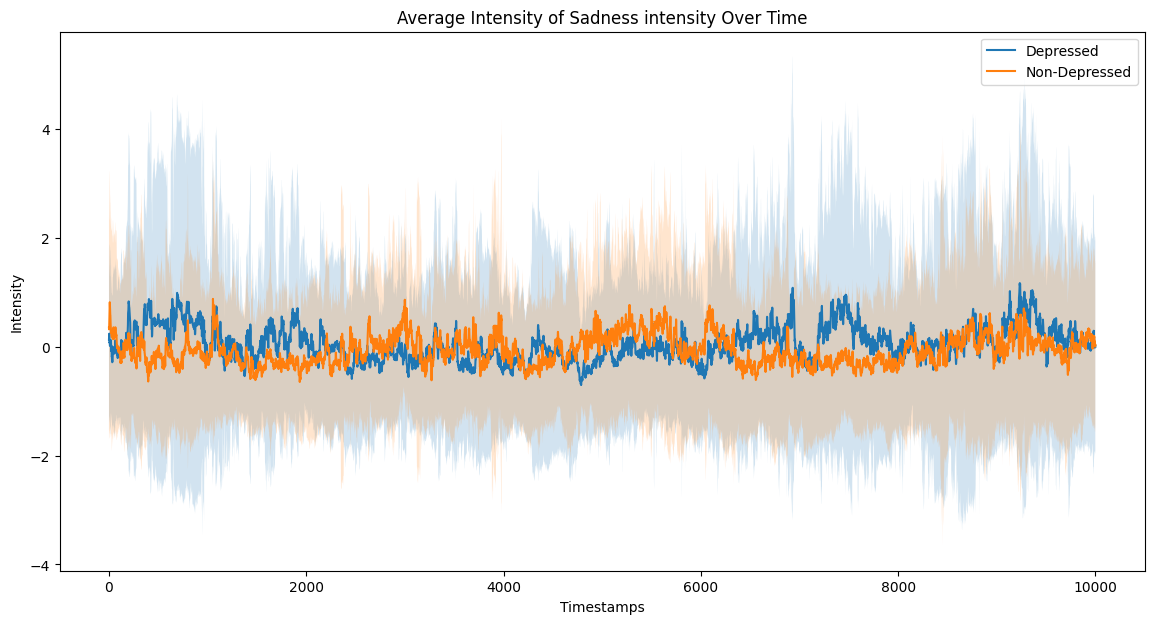

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(mean_depressed, label='Depressed')
plt.plot(mean_non_depressed, label='Non-Depressed')
plt.fill_between(np.arange(max_length_limit), mean_depressed - std_depressed, mean_depressed + std_depressed, alpha=0.2)
plt.fill_between(np.arange(max_length_limit), mean_non_depressed - std_non_depressed, mean_non_depressed + std_non_depressed, alpha=0.2)
plt.legend()
plt.title('Average Intensity of Sadness intensity Over Time')
plt.xlabel('Timestamps')
plt.ylabel('Intensity')
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Extracting features: mean and standard deviation in windows of 100 timestamps
window_size = 500
features_depressed = []
features_non_depressed = []

for i in range(0, max_length_limit, window_size):
    window_depressed = depressed[:, i:i + window_size]
    window_non_depressed = non_depressed[:, i:i + window_size]
    
    mean_depressed = np.mean(window_depressed, axis=1)
    std_depressed = np.std(window_depressed, axis=1)
    mean_non_depressed = np.mean(window_non_depressed, axis=1)
    std_non_depressed = np.std(window_non_depressed, axis=1)
    
    features_depressed.append(np.vstack((mean_depressed, std_depressed)).T)
    features_non_depressed.append(np.vstack((mean_non_depressed, std_non_depressed)).T)

features_depressed = np.hstack(features_depressed)
features_non_depressed = np.hstack(features_non_depressed)

# Combine features and normalize
X = np.vstack((features_depressed, features_non_depressed))
y_combined = np.hstack((np.ones(depressed.shape[0]), np.zeros(non_depressed.shape[0])))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

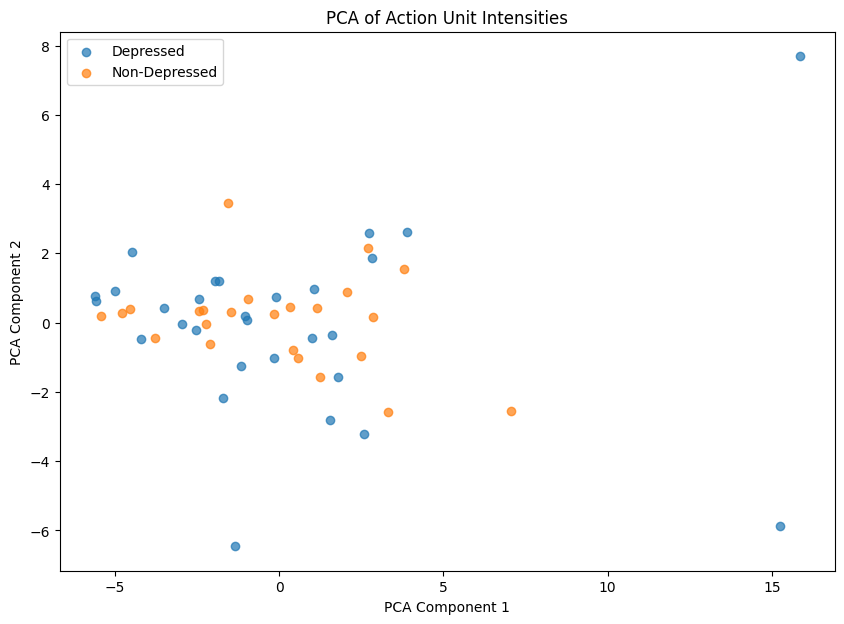

In [9]:
# Reduce dimensions for clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[y_combined == 1][:, 0], X_pca[y_combined == 1][:, 1], label='Depressed', alpha=0.7)
plt.scatter(X_pca[y_combined == 0][:, 0], X_pca[y_combined == 0][:, 1], label='Non-Depressed', alpha=0.7)
plt.title('PCA of Action Unit Intensities')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

/home/woody/iwso/iwso092h/.venv/lib64/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.6899151298295431


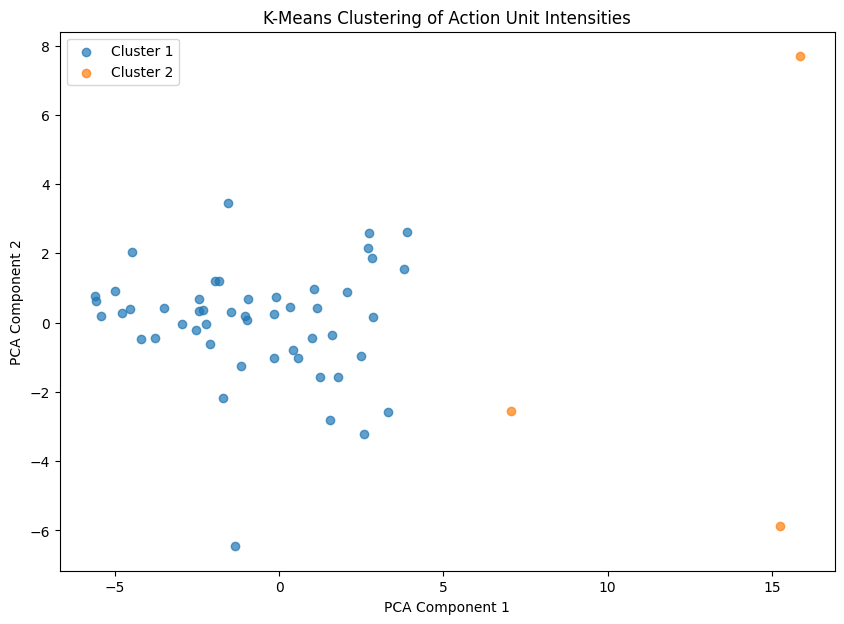

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Silhouette score to evaluate clustering
sil_score = silhouette_score(X_pca, clusters)
print(f'Silhouette Score: {sil_score}')

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[clusters == 0][:, 0], X_pca[clusters == 0][:, 1], label='Cluster 1', alpha=0.7)
plt.scatter(X_pca[clusters == 1][:, 0], X_pca[clusters == 1][:, 1], label='Cluster 2', alpha=0.7)
plt.title('K-Means Clustering of Action Unit Intensities')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

A Silhouette Score of 0.6034 indicates a fairly good clustering structure. This means that the clusters are well-defined, with a reasonable separation between clusters and cohesion within clusters.

Agglomerative Clustering Silhouette Score: 0.7392059599130414


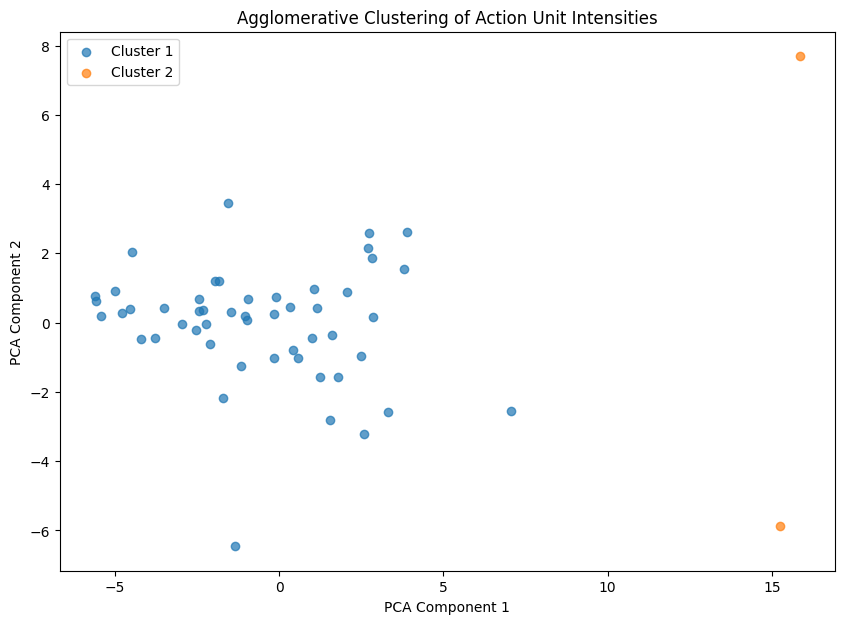

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=2)
clusters_agglo = agglo.fit_predict(X_pca)

# Silhouette score for Agglomerative Clustering
sil_score_agglo = silhouette_score(X_pca, clusters_agglo)
print(f'Agglomerative Clustering Silhouette Score: {sil_score_agglo}')

# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[clusters_agglo == 0][:, 0], X_pca[clusters_agglo == 0][:, 1], label='Cluster 1', alpha=0.7)
plt.scatter(X_pca[clusters_agglo == 1][:, 0], X_pca[clusters_agglo == 1][:, 1], label='Cluster 2', alpha=0.7)
plt.title('Agglomerative Clustering of Action Unit Intensities')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

DBSCAN did not form enough clusters for silhouette score calculation.


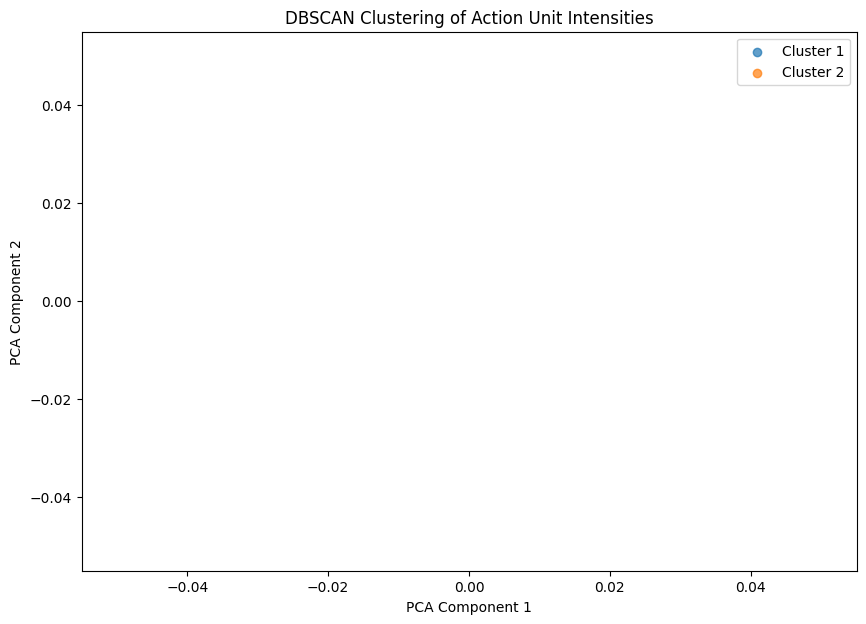

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(X_pca)

# Filtering out noise points
mask = clusters_dbscan != -1
filtered_X_pca = X_pca[mask]
filtered_clusters_dbscan = clusters_dbscan[mask]

# Silhouette score for DBSCAN
if len(set(filtered_clusters_dbscan)) > 1:
    sil_score_dbscan = silhouette_score(filtered_X_pca, filtered_clusters_dbscan)
    print(f'DBSCAN Silhouette Score: {sil_score_dbscan}')
else:
    sil_score_dbscan = 'Not Applicable'
    print('DBSCAN did not form enough clusters for silhouette score calculation.')

# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(filtered_X_pca[filtered_clusters_dbscan == 0][:, 0], filtered_X_pca[filtered_clusters_dbscan == 0][:, 1], label='Cluster 1', alpha=0.7)
plt.scatter(filtered_X_pca[filtered_clusters_dbscan == 1][:, 0], filtered_X_pca[filtered_clusters_dbscan == 1][:, 1], label='Cluster 2', alpha=0.7)
plt.title('DBSCAN Clustering of Action Unit Intensities')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

GMM Silhouette Score: 0.37368720501037633


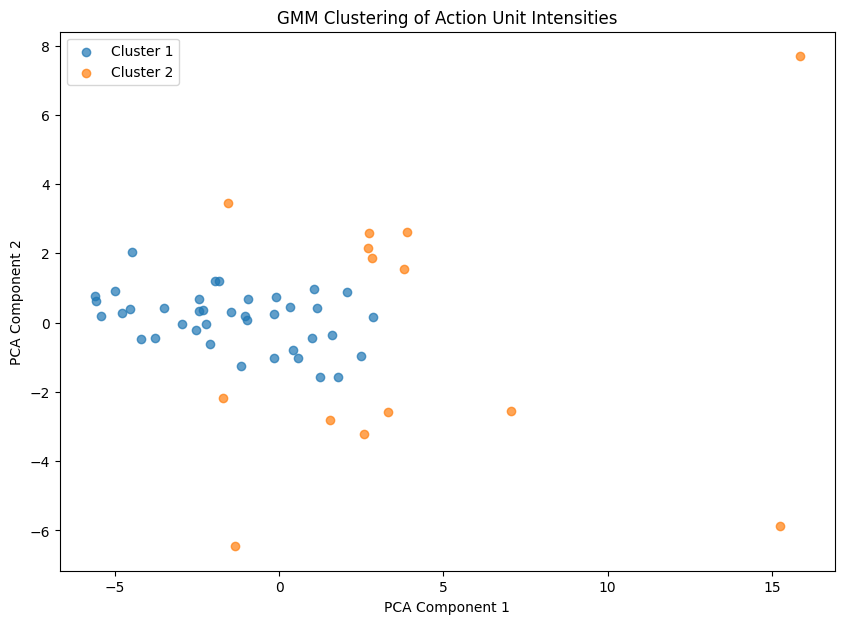

In [13]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
clusters_gmm = gmm.fit_predict(X_pca)

# Silhouette score for GMM
sil_score_gmm = silhouette_score(X_pca, clusters_gmm)
print(f'GMM Silhouette Score: {sil_score_gmm}')

# Plotting the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[clusters_gmm == 0][:, 0], X_pca[clusters_gmm == 0][:, 1], label='Cluster 1', alpha=0.7)
plt.scatter(X_pca[clusters_gmm == 1][:, 0], X_pca[clusters_gmm == 1][:, 1], label='Cluster 2', alpha=0.7)
plt.title('GMM Clustering of Action Unit Intensities')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [14]:
X = summed_array.reshape(53, max_length_limit)

In [15]:
from scipy.stats import ttest_ind

# Separate sadness intensity for both groups
sadness_depressed = X[y == 1]
sadness_non_depressed = X[y == 0]

# Compute the mean sadness intensity for each patient
mean_sadness_depressed = np.mean(sadness_depressed, axis=1)
mean_sadness_non_depressed = np.mean(sadness_non_depressed, axis=1)

# Perform t-test
t_stat, p_value = ttest_ind(mean_sadness_depressed, mean_sadness_non_depressed)
print(f'T-Test: t-statistic = {t_stat}, p-value = {p_value}')

T-Test: t-statistic = 0.35005548666814007, p-value = 0.7277386427094673


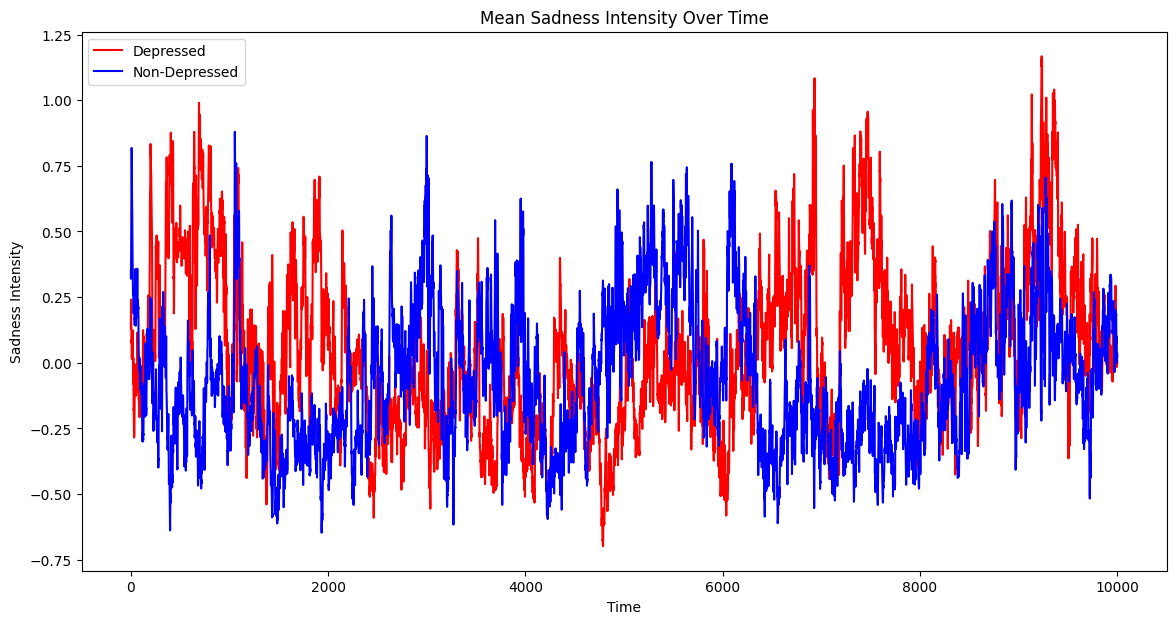

In [16]:
import matplotlib.pyplot as plt

# Compute the mean sadness intensity over time for both groups
mean_time_series_depressed = np.mean(sadness_depressed, axis=0)
mean_time_series_non_depressed = np.mean(sadness_non_depressed, axis=0)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(mean_time_series_depressed, label='Depressed', color='r')
plt.plot(mean_time_series_non_depressed, label='Non-Depressed', color='b')
plt.title('Mean Sadness Intensity Over Time')
plt.xlabel('Time')
plt.ylabel('Sadness Intensity')
plt.legend()
plt.show()

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_proba)}')

# Feature Importance (in this context, it may be less relevant as we only have one feature per timestamp

              precision    recall  f1-score   support

           0       0.67      0.20      0.31        10
           1       0.38      0.83      0.53         6

    accuracy                           0.44        16
   macro avg       0.53      0.52      0.42        16
weighted avg       0.56      0.44      0.39        16

ROC-AUC Score: 0.6333333333333333
